Implement **`one-vs-all logistic regression and neural networks to recognize handwritten digit`**

In [1]:
import numpy  as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy
import scipy.optimize as opt
import scipy.io as sio
from scipy.io import loadmat

%matplotlib inline

# Multi-Class Classification

Extend your previous implementation of logistic regression and apply it to **`one-vs-all classification`**.

###### Load dataset

In [2]:
path = "dataset/ex3data1.mat"
ori_data = sio.loadmat(path)
X_ori = ori_data.get('X')
y_ori = ori_data.get('y').reshape((-1,))
m = y_ori.shape[0]
print(">> X_ori.shape :", X_ori.shape)
print("   y_ori.shape :", y_ori.shape)
print("   Samples :", m)
print("   y classes :", np.unique(y_ori))

>> X_ori.shape : (5000, 400)
   y_ori.shape : (5000,)
   Samples : 5000
   y classes : [ 1  2  3  4  5  6  7  8  9 10]


## Visualizing the data

There are 5000 training examples in `ex4data1.mat`, where each training example is `a 20 pixel by 20 pixel grayscale image of the digit`. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

###### form data for visualize

In [3]:
def form_data_for_visualize(X, y):
    # for this dataset, you need a transpose to get the orientation right
    X_img = np.array([im.reshape((20, 20)).T for im in X])
    # and I flat the image again to preserve the vector presentation
    X_img = np.array([im.reshape(400) for im in X_img])
    y_img = y
    
    return X_img, y_img

###### visualize all data

In [4]:
def visualize_data(X, y):
    img_size = int(np.sqrt(X.shape[1]))
    
    sample_idx = np.sort(np.random.choice(5000, 100))
    sample_img = X[sample_idx, :]
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_img[10 * r + c].reshape((img_size, img_size)),
                                   cmap=mpl.cm.binary) # Greys_r
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

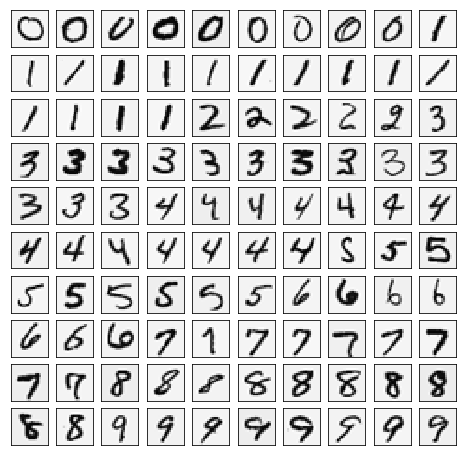

In [5]:
X_img, y_img = form_data_for_visualize(X_ori, y_ori)
visualize_data(X_img, y_img)

###### visualize one image

In [6]:
def visualize_one_image(image, method=0):
    fig, ax = plt.subplots(figsize=(1, 1))
    if method == 0:
        ax.matshow(image.reshape((20, 20)), cmap=mpl.cm.binary)
    elif method == 1:
        plt.imshow(image.reshape((20, 20)), cmap=mpl.cm.binary)
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))

this should be 4


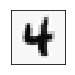

In [7]:
#pick_one = np.random.choice(5000, 1)
pick_one = np.random.randint(0, 5000)
visualize_one_image(X_img[pick_one, :])
print('this should be {}'.format(y_img[pick_one]))

###### visualize all classes data

In [8]:
y_one_class = y_ori.copy()
y_one_class[y_one_class == 10] = 0

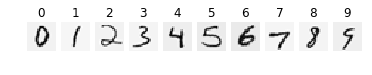

In [9]:
classes = np.arange(0, 10)
num_classes = len(classes)
sample_each_class = 1

for y, cla in enumerate(classes):
    idxs = np.array(np.where(y_one_class == y)).reshape((-1,))
    idxs = np.random.choice(idxs, sample_each_class, replace=False)

    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_each_class, num_classes, plt_idx)
        plt.imshow(X_img[idx].reshape((20, 20)), cmap=mpl.cm.binary)
        plt.axis('off')
        if i == 0:
            plt.title(cla)


##### form training data

In [10]:
def form_train_data(X_ori, y_ori):
    X_train = np.insert(X_ori, 0, 1, axis=1)
    
    # transform vector-y to one-hot
    y_matrix = []
    for k in range(1,11):
        y_matrix.append((y_ori == k).astype(int))
        # y_matrix.append([1 if label == k else 0 for label in y])
    y_matrix = [y_matrix[-1]] + y_matrix[:-1]
    y_train = np.array(y_matrix)
    
    print("X_train.shape :", X_train.shape)
    print("y_train.shape :", y_train.shape)
    
    return X_train, y_train

X_train, y_train = form_train_data(X_ori, y_ori)
theta_init_zero = np.zeros((X_train.shape[1],))

X_train.shape : (5000, 401)
y_train.shape : (10, 5000)


## Vetor regularization logistic regression

**`Using multiple one-vs-all logistic regression models to build a multi-class classifier`**.

`Since there are 10 classes, you will need to train 10 separate logistic regression classifiers`. 

In [11]:
J_history = []
theta_init_zero = np.zeros((X_train.shape[1],))

In [12]:
def sigmoid(Z):
    return scipy.special.expit(Z)

In [13]:
def hypothesis(theta, X):
    return sigmoid(X @ theta)

+ Normal : $ J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{[{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]} + \frac{\lambda }{2m}\sum\limits_{j=1}^{n}{{\theta }_{j}^{2}} $
+ Vector : $ J(\theta) = -\frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda }{2m}\sum\limits_{j=1}^{n}{{\theta }_{j}^{2}} $
> + theta - (n+1, )
> + X - (m, n+1)
> + y - (m, )
> + scalars

In [14]:
def replace_zeros(data):
    if np.count_nonzero(data):
        min_nonzero = np.min(data[np.nonzero(data)])
    else:
        min_nonzero = 0.000000000001
    data[data == 0] = min_nonzero
    
    return data


def cost_function(theta, X, y, lamd=0):
    global J_history
    
    hyp = hypothesis(theta, X)
    y_1 = np.log(replace_zeros(hyp)).T @ y
    y_0 = np.log(replace_zeros(1-hyp)).T @ (1-y)
    cost = -(y_1 + y_0) / y.size
    
    reg_item = lamd * np.mean(np.power(theta[1:], 2)) / (2 * y.size)
    cost_reg = cost + reg_item
    
    """
        if np.isnan(cost_reg):
            cost_reg = np.inf
    """

    J_history.append(cost_reg)
    
    return cost_reg

In [15]:
cost_function(theta_init_zero, X_train, y_train[0])

0.6931471805599467

+ Vector : $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$ 
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$
> + theta - (n+1, )
> + X - (m, n+1)
> + y - (m, )
> + (n+1, )

In [16]:
def gradient(theta, X, y, lamd=0):
    err = hypothesis(theta, X) - y
    grad = X.T @ err / y.size
    
    reg_theta = lamd * theta[1:] / y.size
    reg_item = np.r_[[0], reg_theta]
    
    grad_reg = grad + reg_item
    
    return grad_reg

In [17]:
def scipy_opt_minimize(theta, X, y, Method, lamd=0):
    global J_history
    J_history = []
    res = opt.minimize(
        fun    = cost_function,
        x0     = theta,
        args   = (X, y, lamd),
        jac    = gradient,
        method = Method
    )
    
    return {
        "result"  : res,
        "theta"   : res.x,
        "success" : res.success,
        "cost_history" : J_history.copy(),
        "name" : Method,
        "lamd" : lamd
    }

## Training One Class Data

In [18]:
res_digit_0 = scipy_opt_minimize(theta_init_zero, X_train, y_train[0], "BFGS", lamd=1)
print("Train result :", res_digit_0["success"])

Train result : False


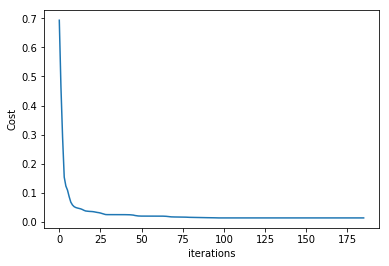

In [19]:
def plot_convergence_curves(J_history, lamd=0, axes=None):
    if axes == None:
        axes = plt.gca()
    
    axes.plot(np.arange(len(J_history)), J_history)
    axes.set_xlabel("iterations")
    axes.set_ylabel("Cost")
    
    ind = np.where(J_history == np.min(J_history))
    j_min = np.array(J_history)[ind]
    ind = np.arange(len(J_history))[ind]
    if len(ind) == 1:
        axes.scatter(ind, j_min, c='r', marker='x', label="lamd - {%.3f} / min - {%d - %0.4f}" % (lamd, ind, j_min))
        axes.legend()

plot_convergence_curves(res_digit_0["cost_history"], res_digit_0["lamd"])

### Accuracy

In [20]:
from sklearn.metrics import classification_report

In [21]:
y_matrix = []
y_matrix.append([1 if label == 10 else 0 for label in y_ori])
y_vector_for_accuary_digit_0 = np.array(y_matrix).reshape((-1,))

In [22]:
y_vector_for_accuary_digit_0.shape

(5000,)

In [23]:
hyp_digit_0 = hypothesis(res_digit_0["theta"], X_train)

In [24]:
print(classification_report(y_vector_for_accuary_digit_0, hyp_digit_0.round().astype(int)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4500
          1       0.99      0.98      0.98       500

avg / total       1.00      1.00      1.00      5000



## Training all Class Data

    Since there are 10 classes, you will need to train 10 separate logistic regression classifiers, one for each of the K classes in our dataset

In [25]:
y_train.shape

(10, 5000)

In [26]:
y_train

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [27]:
theta_scipy_opt = []
for i in range(10):
    res = scipy_opt_minimize(theta_init_zero, X_train, y_train[i], "BFGS", lamd=1)
    theta_scipy_opt.append(res["theta"])

theta_scipy_opt = np.array(theta_scipy_opt)

### Accuracy

#### classification_report

In [28]:
theta_scipy_opt.shape

(10, 401)

In [29]:
hyp_prd = hypothesis(theta_scipy_opt.T, X_train)
y_prd   = np.argmax(hyp_prd, axis=1)

In [30]:
y_answer = y_ori.copy()
y_answer[y_answer == 10] = 0

In [31]:
print(classification_report(y_answer, y_prd))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       500
          1       0.95      0.97      0.96       500
          2       0.93      0.90      0.92       500
          3       0.93      0.90      0.91       500
          4       0.94      0.95      0.94       500
          5       0.90      0.90      0.90       500
          6       0.95      0.97      0.96       500
          7       0.94      0.94      0.94       500
          8       0.91      0.91      0.91       500
          9       0.91      0.91      0.91       500

avg / total       0.93      0.93      0.93      5000



#### np.mean()

In [32]:
corret = [1 if a == b else 0 for (a,b) in zip (y_answer, y_prd)]
accu   = sum(map(int, corret)) / float(len(corret))
print('Accuracy = {0}%'.format(accu * 100))

Accuracy = 93.38%


#### model.score()

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
model = LogisticRegression(penalty='l2', C=1.0, fit_intercept=False, multi_class='ovr')
model.fit(X_train, y_ori)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
model.coef_.shape

(10, 401)

In [36]:
model.score(X_train, y_ori)

0.944

### choose best lamd

In [37]:
from sklearn.model_selection import *

In [38]:
y_choose_lamd = y_ori.copy()
sk_X_train, sk_X_test, sk_y_train, sk_y_test = train_test_split(
    X_train, y_choose_lamd, test_size=0.3, random_state=0
)
sk_X_img, sk_y_img = form_data_for_visualize(sk_X_train[:,1:], sk_y_train)

>>>  Lamd = 100.000000
     train acu = 88.029%
     cv acu    = 89.333%

>>>  Lamd = 0.004000
     train acu = 97.714%
     cv acu    = 98.267%

>>>  Lamd = 0.002000
     train acu = 97.943%
     cv acu    = 98.467%

>>>  Lamd = 0.001333
     train acu = 98.086%
     cv acu    = 98.533%

>>>  Lamd = 0.001000
     train acu = 98.143%
     cv acu    = 98.533%



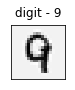

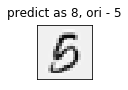

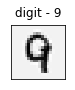

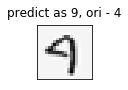

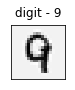

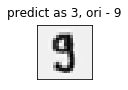

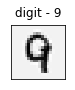

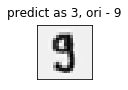

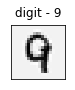

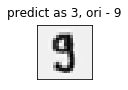

In [39]:
lamdas = np.linspace(0.01, 1000, 5)

acu_train = np.empty(len(lamdas))
acu_cv = np.empty(len(lamdas))

for i, lamda in enumerate(lamdas):
    model = LogisticRegression(penalty='l2', C=lamda, fit_intercept=False, multi_class='ovr')
    model.fit(X_train, y_ori)
    
    # calc accuracy - method-01
    hyp_prd_train = hypothesis(model.coef_.T, sk_X_train)
    y_prd_train   = np.argmax(hyp_prd_train, axis=1) + 1
    y_answer_train = sk_y_train.copy()
    corret_train = [1 if a == b else 0 for (a,b) in zip (y_answer_train, y_prd_train)]
    acu_train[i]   = np.mean(corret_train)
    
    hyp_prd_cv = hypothesis(model.coef_.T, sk_X_test)
    y_prd_cv   = np.argmax(hyp_prd_cv, axis=1) + 1
    y_answer_cv = sk_y_test.copy()
    corret_cv = [1 if a == b else 0 for (a,b) in zip (y_answer_cv, y_prd_cv)]
    acu_cv[i]   = np.mean(corret_cv)

    # calc accuracy - method-02
    # acu_train[i] = model.score(sk_X_train, sk_y_train)
    # acu_cv[i] = model.score(sk_X_test, sk_y_test)

    print('>>>  Lamd = %f' % (1 / lamda))
    print('     train acu = %.3f%%' % (acu_train[i] * 100))
    print('     cv acu    = %.3f%%' % (acu_cv[i] * 100))
    print()
    
    # plot digit-0
    digit_show = 9
    ind = np.where(sk_y_train == digit_show)
    visualize_one_image(sk_X_img[ind][0])
    axes = plt.gca()
    axes.set_title('digit - %d' % (digit_show))
    
    # plot error predict digit
    inct_ind = np.where(y_answer_train != y_prd_train)
    visualize_one_image(sk_X_img[inct_ind][0])
    axes = plt.gca()
    axes.set_title('predict as %d, ori - %d' % (y_prd_train[inct_ind][0] , y_answer_train[inct_ind][0]))

3


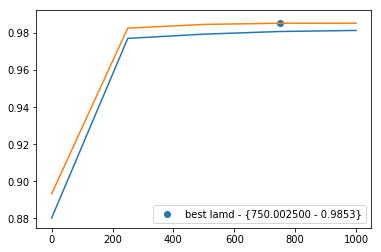

In [40]:
plt.plot(lamdas, acu_train, lamdas, acu_cv)
ind = np.where(acu_cv == np.amax(acu_cv))
print(ind[0][0])
optLambda = lamdas[ind[0][0]]
plt.scatter(optLambda, acu_cv[ind[0][0]], label="best lamd - {%f - %0.4f}" % (optLambda, acu_cv[ind[0][0]]))
plt.legend()

# Neural Network

    However, logistic regression can't form more complex hypothesis as it is only a linear classifier

<img style="float: left;" src="dataset/nn_model.png">

In [41]:
def load_weight(path):
    weights = sio.loadmat(path)
    print('weight.keys()', weights.keys())
    print('weights[\'Theta1\'].shape', weights['Theta1'].shape)
    print('weights[\'Theta2\'].shape', weights['Theta2'].shape)
    
    return weights['Theta1'], weights['Theta2']

In [42]:
weights_path = "dataset/ex3weights.mat"
theta1, theta2 = load_weight(weights_path)

weight.keys() dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])
weights['Theta1'].shape (25, 401)
weights['Theta2'].shape (10, 26)


theta - (out, in)
z - (m, n)
Z - (m, out)

## layer()

In [43]:
def layer(theta, z):
    print(theta.shape)
    print(z.shape)
    
    z_bias = np.insert(z, 0, 1, axis=1)
    print(z_bias.shape)
    Z = z_bias @ theta.T
    a = sigmoid(Z)
    print(a.shape)
    return a

a1 = layer(theta1, X_ori)

(25, 401)
(5000, 400)
(5000, 401)
(5000, 25)


In [44]:
a2 = layer(theta2, a1)

(10, 26)
(5000, 25)
(5000, 26)
(5000, 10)


In [45]:
a2[0]

array([1.12661530e-04, 1.74127856e-03, 2.52696959e-03, 1.84032321e-05,
       9.36263860e-03, 3.99270267e-03, 5.51517524e-03, 4.01468105e-04,
       6.48072305e-03, 9.95734012e-01])

In [46]:
y_pred = np.argmax(a2, axis=1) + 1
y_pred.shape

(5000,)

In [47]:
print(classification_report(y_ori, y_pred))

             precision    recall  f1-score   support

          1       0.97      0.98      0.98       500
          2       0.98      0.97      0.98       500
          3       0.98      0.96      0.97       500
          4       0.97      0.97      0.97       500
          5       0.97      0.98      0.98       500
          6       0.98      0.99      0.98       500
          7       0.98      0.97      0.97       500
          8       0.98      0.98      0.98       500
          9       0.97      0.96      0.96       500
         10       0.98      0.99      0.99       500

avg / total       0.98      0.98      0.98      5000



In [48]:
corret = [1 if a == b else 0 for (a,b) in zip (y_ori, y_pred)]
accu   = sum(map(int, corret)) / float(len(corret))
print('Accuracy = {0}%'.format(accu * 100))

Accuracy = 97.52%


In [49]:
accu   = np.mean(y_pred == y_ori)
print('Accuracy = {0}%'.format(accu * 100))

Accuracy = 97.52%


## visualize incorrect digit

In [50]:
def visualize_incorrect_data(X, y):
    img_size = int(np.sqrt(X.shape[1]))
    num = int(np.sqrt(len(y)))
    
    #sample_idx = np.sort(np.random.choice(len(X), 100))
    
    fig, ax_array = plt.subplots(nrows=num, ncols=num, sharey=True, sharex=True, figsize=(18, 18))
    for r in range(num):
        for c in range(num):
            ax_array[r, c].matshow(X[num * r + c].reshape((img_size, img_size)),
                                   cmap=mpl.cm.binary) # Greys_r
            ax_array[r, c].set_title("Predicted as %d" % y[num * r + c])
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

In [51]:
X_inc = X_img[y_pred != y_ori]
y_inc = y_pred[y_pred != y_ori]

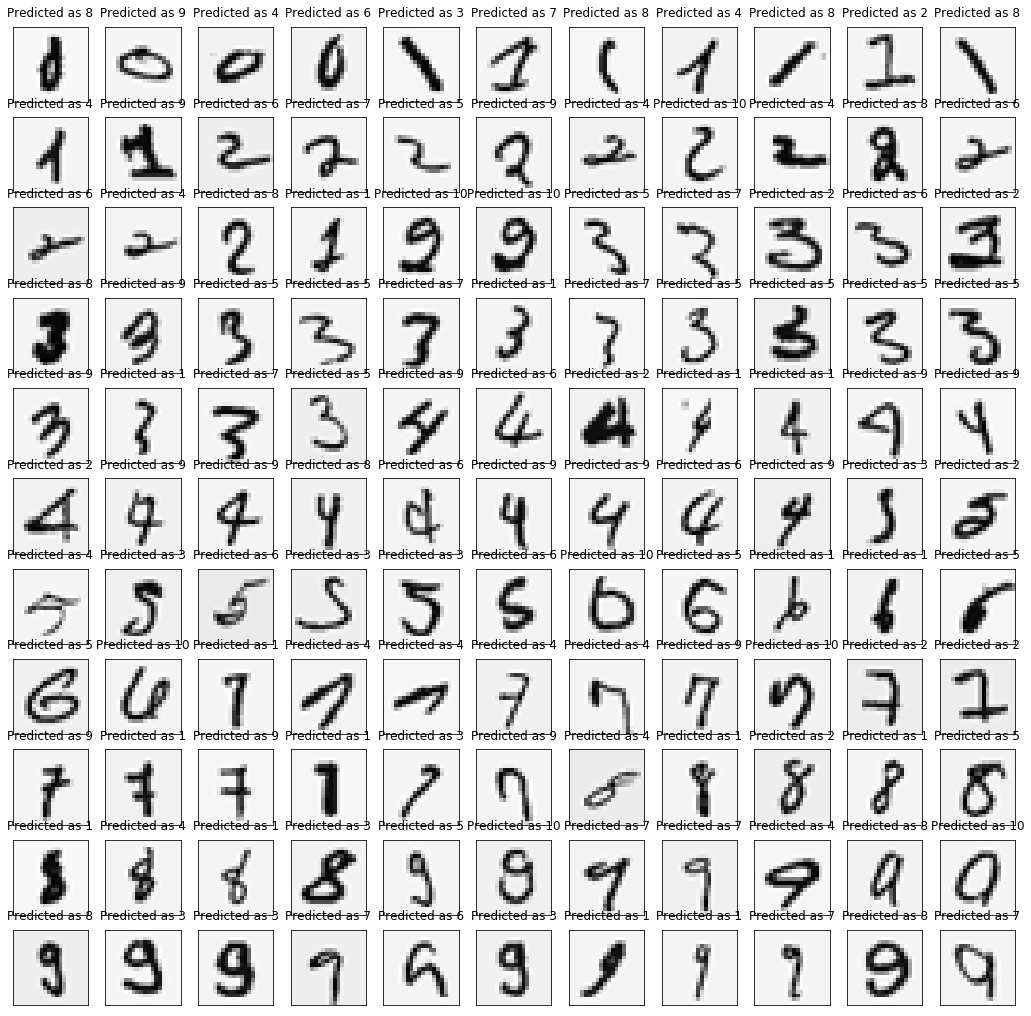

In [52]:
visualize_incorrect_data(X_inc, y_inc)